World Coins: A collection of coin images from 32 different currencies.

In [17]:
# Seznam knihoven
import os
import numpy as np
import random
import kaggle
import shutil
import concurrent.futures
import matplotlib.pyplot as plt
import concurrent.futures
from PIL import Image
from sklearn.cluster import MiniBatchKMeans
from pathlib import Path
from PIL import Image

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import zscore


In [11]:
# Stažení dat z Kaggle přes API token
kaggle.api.dataset_download_files('wanderdust/coin-images', path='./data', unzip=True)
print("Dataset byl úspěšně stažen a rozbalen do složky ./data!")

Dataset URL: https://www.kaggle.com/datasets/wanderdust/coin-images
Dataset byl úspěšně stažen a rozbalen do složky ./data!


In [3]:
# Napojení dat a vytvoření cesty
data_dir_train = "data/coins/data/train/"
data_dir_val = "data/coins/data/validation/"
data_dir_test = "data/coins/data/test/"
outlier_dir = "data/coins/data/outliers"
json_path = "data/cat_to_name.json"

Ořezání pravého okraje obrázku o 8 % pro odstranění vodoznaku

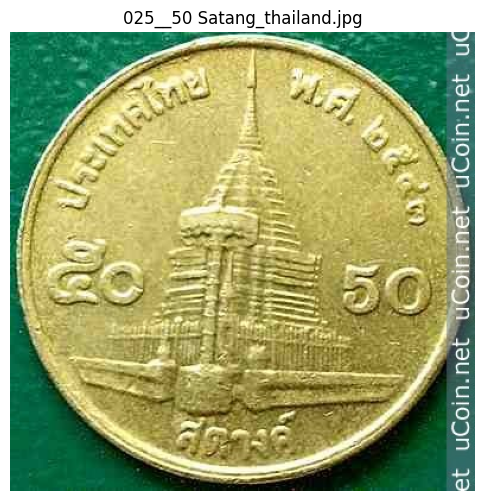

In [12]:
def get_random_image(directory):
    all_folders = [os.path.join(directory, folder) for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    random_folder = random.choice(all_folders)
    all_images = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return random.choice(all_images)
random_image_path = get_random_image(data_dir_train)
if random_image_path:
    img = Image.open(random_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{os.path.basename(random_image_path)}")
    plt.show()

In [13]:
def crop_images_in_directory(directory, crop_percentage=0.08):
    """ Ořízne pravý okraj všech obrázků v daném adresáři a jeho podsložkách. """
    directory = Path(directory)

    for file_path in directory.rglob('*.[jp][pn]g'):  # Hledá soubory s příponami .jpg, .jpeg, .png
        with Image.open(file_path) as img:
            new_width = int(img.width * (1 - crop_percentage))
            img.crop((0, 0, new_width, img.height)).save(file_path)  # Ořízne a uloží zpět
            print(f"Ořezáno: {file_path}")  # Debug informace

# Spuštění pro test a validation
crop_images_in_directory(data_dir_train)
crop_images_in_directory(data_dir_val)

print("Všechny obrázky byly úspěšně oříznuty.")

Ořezáno: data\coins\data\train\1\001__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\002__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\004__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\005__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\007__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\008__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\009__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\010__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\011__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\012__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\014__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\015__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\016__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\017__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\018__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\019__1 Cent_australia.jpg
Ořezáno: data\coins\data\train\1\020__1 Cent_australia.j

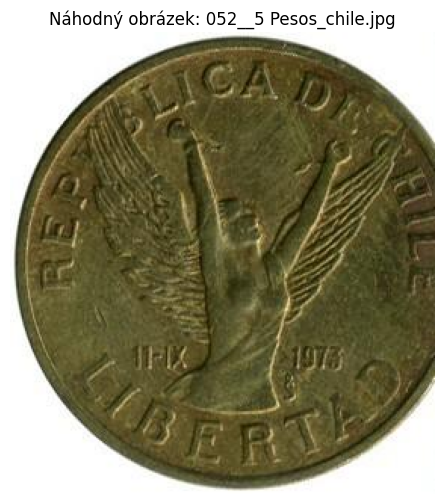

In [14]:
def get_random_image(directory):
    all_folders = [os.path.join(directory, folder) for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    random_folder = random.choice(all_folders)
    all_images = [os.path.join(random_folder, img) for img in os.listdir(random_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return random.choice(all_images)
random_image_path = get_random_image(data_dir_train)
if random_image_path:
    img = Image.open(random_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Náhodný obrázek: {os.path.basename(random_image_path)}")
    plt.show()

Automatické odstranění outliers přes clustering

In [ ]:
# 📌 Nastavení
IMG_SIZE = (224, 224)  # Velikost obrázků pro MobileNetV2
N_CLUSTERS = 2         # Počet clusterů pro KMeans
BATCH_SIZE = 32        # Velikost dávky pro MiniBatchKMeans

# 📦 Cesty k datům
OUTLIER_DIR = Path("data/coins/data/outliers")
OUTLIER_DIR.mkdir(parents=True, exist_ok=True)  # Vytvoření složky pro outliery

# 🔍 Rychlejší model pro extrakci příznaků
feature_extractor = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")

# 🔹 Funkce pro extrakci příznaků
def extract_features(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return feature_extractor.predict(img_array, verbose=0).flatten()

# 🔄 Hlavní funkce pro clustering
def cluster_and_clean_dataset(root_dir, max_images=500):
    root_dir = Path(root_dir)
    
    for category_path in root_dir.iterdir():  # Prochází kategorie (složky)
        if not category_path.is_dir():
            continue
        
        outlier_category_path = OUTLIER_DIR / category_path.name
        outlier_category_path.mkdir(parents=True, exist_ok=True)

        # 📂 Seznam obrázků
        image_files = list(category_path.glob("*.jpg")) + list(category_path.glob("*.png"))
        if len(image_files) < 2:
            continue

        # 📉 Omezit počet obrázků pro rychlejší testování
        image_files = image_files[:max_images] if len(image_files) > max_images else image_files

        # ⚡ Paralelní extrakce příznaků
        with concurrent.futures.ThreadPoolExecutor() as executor:
            features = np.array(list(executor.map(extract_features, image_files)))

        # 📊 Clustering pomocí MiniBatchKMeans
        kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, batch_size=BATCH_SIZE, random_state=42).fit(features)
        
        # 📉 Výpočet vzdáleností a detekce outlierů
        distances = np.min(kmeans.transform(features), axis=1)  # Nejkratší vzdálenost ke clustru
        z_scores = zscore(distances)  # Standardizace vzdáleností (z-score)
        outlier_images = [image_files[i] for i in range(len(image_files)) if z_scores[i] > 2.0]  # 2 sigma jako práh

        # 🗑️ Přesun outlierů
        for img_path in outlier_images:
            shutil.move(str(img_path), str(outlier_category_path / img_path.name))

        print(f"📦 Kategorie {category_path.name}: {len(outlier_images)} outlierů přesunuto.")

# 🚀 Spuštění clusteringu
cluster_and_clean_dataset("data/coins/data/train")
cluster_and_clean_dataset("data/coins/data/validation")


C:\Users\MilanPštross\AppData\Local\Temp\ipykernel_10156\4255822743.py:23: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_extractor = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


📦 Kategorie 1: 0 outlierů přesunuto.
📦 Kategorie 10: 1 outlierů přesunuto.
📦 Kategorie 100: 0 outlierů přesunuto.
📦 Kategorie 101: 1 outlierů přesunuto.
📦 Kategorie 102: 2 outlierů přesunuto.
📦 Kategorie 103: 0 outlierů přesunuto.
📦 Kategorie 104: 1 outlierů přesunuto.
📦 Kategorie 105: 0 outlierů přesunuto.
📦 Kategorie 106: 0 outlierů přesunuto.
📦 Kategorie 107: 2 outlierů přesunuto.
📦 Kategorie 108: 0 outlierů přesunuto.
📦 Kategorie 109: 1 outlierů přesunuto.
📦 Kategorie 11: 1 outlierů přesunuto.
📦 Kategorie 110: 0 outlierů přesunuto.
📦 Kategorie 111: 0 outlierů přesunuto.
📦 Kategorie 112: 0 outlierů přesunuto.
📦 Kategorie 113: 1 outlierů přesunuto.
📦 Kategorie 114: 0 outlierů přesunuto.
📦 Kategorie 115: 0 outlierů přesunuto.
📦 Kategorie 116: 1 outlierů přesunuto.
📦 Kategorie 117: 0 outlierů přesunuto.
📦 Kategorie 118: 1 outlierů přesunuto.
📦 Kategorie 119: 1 outlierů přesunuto.
📦 Kategorie 12: 0 outlierů přesunuto.
📦 Kategorie 120: 1 outlierů přesunuto.
📦 Kategorie 121: 0 outlierů př